In [1]:
!pip install tensorflow_datasets

## Ungraded Lab: MNIST Autoencoder

You will now work on an autoencoder that works on the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist). This will encode the inputs to lower resolution images. The decoder should then be able to generate the original input from this compressed representation.

## Imports

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
def map_image_with_noise(image, label):
  noise_factor=0.5
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  factor=noise_factor*tf.random.normal(shape=image.shape)
  image_noisy=image+factor
  image_noisy=tf.clip_by_value(image_noisy,0.0,1.0)
  # image = tf.reshape(image, shape=(28,28,1))

  return image_noisy, image

## Prepare the Dataset

You will load the MNIST data from TFDS into train and test sets. Let's first define a preprocessing function for normalizing and flattening the images. Since we'll be training an autoencoder, this will return `image, image` because the input will also be the target or label while training.


In [4]:
# Load the train and test sets from TFDS

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image_with_noise)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image_with_noise)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.CUIAQT_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.CUIAQT_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## Build the Model

You will now build a simple autoencoder to ingest the data. Like before, the encoder will compress the input and reconstructs it in the decoder output. ![Autoencoder Flowchart](auto.png)

In [5]:
#Bulid the Model

def encoder(inputs):
  conv_1=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3) , activation='relu',padding='same')(inputs)
  max_pool_1=tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2=tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(max_pool_1)
  max_pool_2=tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2

def bottle_neck(inputs):
  bottle_neck=tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same')(inputs)

  encoder_visualisation=tf.keras.layers.Conv2D(filters=1,kernel_size=(3,3),activation='sigmoid',padding='same')(bottle_neck)

  return bottle_neck,encoder_visualisation

def decoder(inputs):
  conv_1=tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(inputs)
  up_sample_1=tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2=tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(up_sample_1)
  up_sample_2=tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  conv_3=tf.keras.layers.Conv2D(filters=1,kernel_size=(3,3),activation='sigmoid',padding='same')(up_sample_2)

  return conv_3


def cnn_auto_encoder():
  inputs=tf.keras.Input(shape=(28,28,1))

  encoderoutput=encoder(inputs)

  bottleneckoutput,encoder_visualisation=bottle_neck(encoderoutput)

  decoderoutput=decoder(bottleneckoutput)

  model=tf.keras.Model(inputs=inputs,outputs=decoderoutput)

  encoder_model=tf.keras.Model(inputs=inputs,outputs=encoder_visualisation)

  return model,encoder_model

In [6]:
cnn_autoencoder_model,cnn_encoder_model=cnn_auto_encoder()
cnn_autoencoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 739,073 (2.82 MB)

 Trainable params: 739,073 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

## Compile the Model

You will setup the model for training. You can use binary crossentropy to measure the loss between pixel values that range from 0 (black) to 1 (white).

In [7]:
# Compile the model using Adam Optimizer , binary_crossentropy and  metrics=['accuracy']

cnn_autoencoder_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

## Train the Model

In [8]:
# train the model using train_dataset,steps_per_epoch=step,epochs=10
step=256

cnn_autoencoder_model.fit(train_dataset,steps_per_epoch=step,epochs=10)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.4917 - loss: 0.4153
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.5061 - loss: 0.3024
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5060 - loss: 0.2967
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5085 - loss: 0.2924
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5081 - loss: 0.2913
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5074 - loss: 0.2897
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5080 - loss: 0.2879
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5073 - loss: 0.2874
Epoch 9/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5077 - loss: 0.2865
Epoch 10/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5093 - loss: 0.2844


## Display sample results

You can now visualize the results. The utility functions below will help in plotting the encoded and decoded values.

In [9]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(7,7,)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


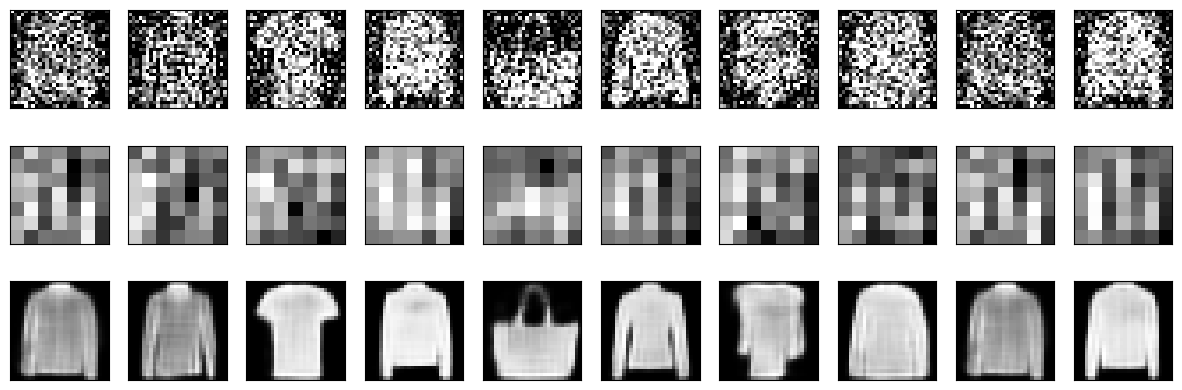

In [10]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 random numbers to be used as indices to the list above
idxs = np.random.choice(BATCH_SIZE, size=10)

# get the encoder output
encoded_predicted = cnn_encoder_model.predict(test_dataset)

# get a prediction for the test batch
simple_predicted = cnn_autoencoder_model.predict(test_dataset)

# display the 10 samples, encodings and decoded values!
display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs])